In [2]:
import pandas as pd
from json import loads as convert_to_list # convert the stored str to list 

# path to data containing change point and their locations 
windowLen = 250
M_welch = 2
f_sampling = 250

hyper_param = f"location-windowLen{windowLen}-Welch{M_welch}"
file_path = "Output/" + hyper_param +".csv"
df = pd.read_csv(file_path,dtype={"subject": str})

df.head()

,subject,region,epoch,eyeState,CpLoc_delta,CpLoc_theta,CpLoc_alpha,CpLoc_beta_smr,CpLoc_beta,CpLoc_gamma
0,010002,1,1,1,[],"[8,53,53,54]",[],[16],[48],"[7,39]"
1,010002,2,1,1,[],[],"[28,29]","[52,54]","[34,37,41,47]",[]
2,010002,3,1,1,[],"[31,50]","[9,22,26,26,29,49]","[43,44,50,54,55,55]","[41,42,46]","[16,29]"
3,010002,4,1,1,[],[],[],[],[],[]
4,010002,5,1,1,[],[],[],"[48,55,56]",[55],"[4,7]"


In [3]:
sub_ids = []
for subject in df.subject.unique():
    # must has 8 epochs with open eyes and closed eyes to be included in sub_ids
    if len(df[(df["subject"] == subject) & (df["eyeState"] == 0)].epoch.unique()) == 8 and len(df[(df["subject"] == subject) & (df["eyeState"] == 1)].epoch.unique()) == 8:
        sub_ids.append(subject)
len(sub_ids)

197

In [4]:
def get_cp_loc(subject="010002", region=1, freq_band="alpha", eyeState=0, all_regions=False):
    freq_col = f"CpLoc_{freq_band}"
    
    # Filter DataFrame based on region condition
    if all_regions:
        tmp_df = df[(df["subject"] == subject) & (df["eyeState"] == eyeState)][["epoch", freq_col]]
    else:
        tmp_df = df[(df["subject"] == subject) & (df["region"] == region) & (df["eyeState"] == eyeState)]#[["epoch", freq_col]]
   
    if tmp_df.empty:
        return []  # Return empty list if no data is found

    cp_loc = []

    # Use .iterrows() for efficiency
    for _, row in tmp_df.iterrows():
        epoch = row["epoch"]
        cp_vals = row[freq_col]

        if pd.isna(cp_vals):  # Handle missing values
            continue  

        tmp_cp = convert_to_list(cp_vals)  # Convert stored string/list to list
        tmp_cp = np.array(tmp_cp) + (epoch - 1) * 60  # Adjust for epoch
        cp_loc.extend(tmp_cp.tolist())  # Extend the list

    return sorted(cp_loc)  # Sort only once at the end


In [5]:
import numpy as np

def create_count_vector(cp_loc, total_time=60*8, moving_average = 1):
    count_vector = np.zeros(total_time, dtype=int)  

    for t in cp_loc:
        if 0 <= t < total_time:  
            count_vector[t] += 1  
    # if the moving_average > 1, then we will use a moving average filter to smooth the count_vector
    if moving_average > 1:
        count_vector = np.convolve(count_vector, np.ones(moving_average)/moving_average, mode='same')
    return count_vector

def counting_process(cp_loc, total_time=60*8):
    count_vector = np.zeros(total_time, dtype=int)  

    for t in cp_loc:
        if 0 <= t < total_time:  
            count_vector[t] += 1  

    return np.cumsum(count_vector)  

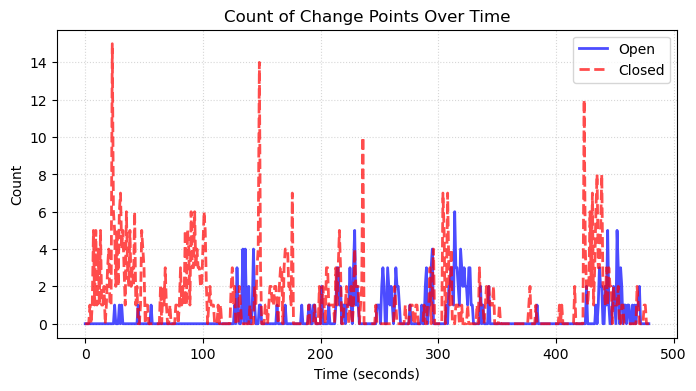

In [6]:
import matplotlib.pyplot as plt

count_vec_o = get_cp_loc(subject=sub_ids[5], all_regions=True, freq_band="alpha", eyeState=1)
count_vec_c = get_cp_loc(subject=sub_ids[5], all_regions=True, freq_band="alpha", eyeState=0)

count_o = create_count_vector(count_vec_o)
count_c = create_count_vector(count_vec_c)

plt.figure(figsize=(8, 4))  # Set figure size

plt.plot(count_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
plt.plot(count_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

plt.xlabel("Time (seconds)")
plt.ylabel("Count")
plt.title("Count of Change Points Over Time")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)  # Light dashed grid for better readability

plt.show()

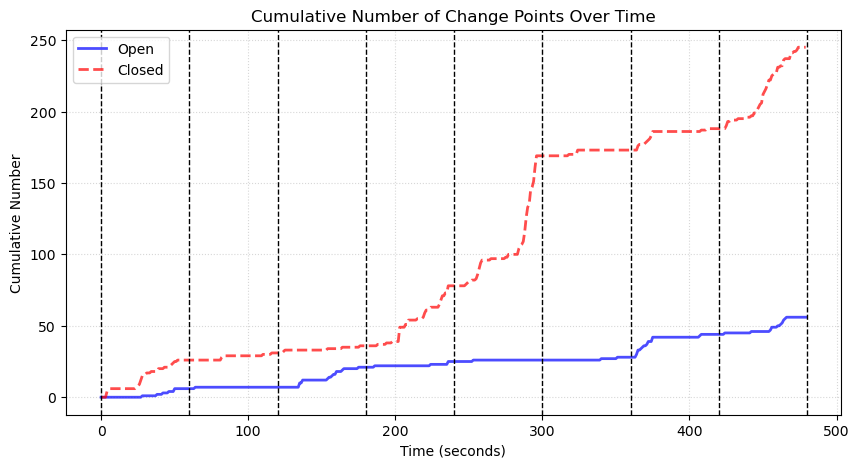

In [7]:
import matplotlib.pyplot as plt

count_vec_o = get_cp_loc(subject=sub_ids[2], all_regions=True, freq_band="alpha", eyeState=1)
count_vec_c = get_cp_loc(subject=sub_ids[2], all_regions=True, freq_band="alpha", eyeState=0)

count_o = counting_process(count_vec_o)
count_c = counting_process(count_vec_c)

plt.figure(figsize=(10, 5))  # Set figure size

plt.plot(count_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
plt.plot(count_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

# Add dashed black lines every 60 seconds
for t in range(0, max(len(count_o), 9*60), 60):
    plt.axvline(x=t, color="black", linestyle="--", linewidth=1)

plt.xlabel("Time (seconds)")
plt.ylabel("Cumulative Number")
plt.title("Cumulative Number of Change Points Over Time")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)  # Light dashed grid for better readability

plt.savefig("Figures/Cumulative number of cp for a signle subject"+ hyper_param+".png", dpi=300, bbox_inches="tight")

plt.show()

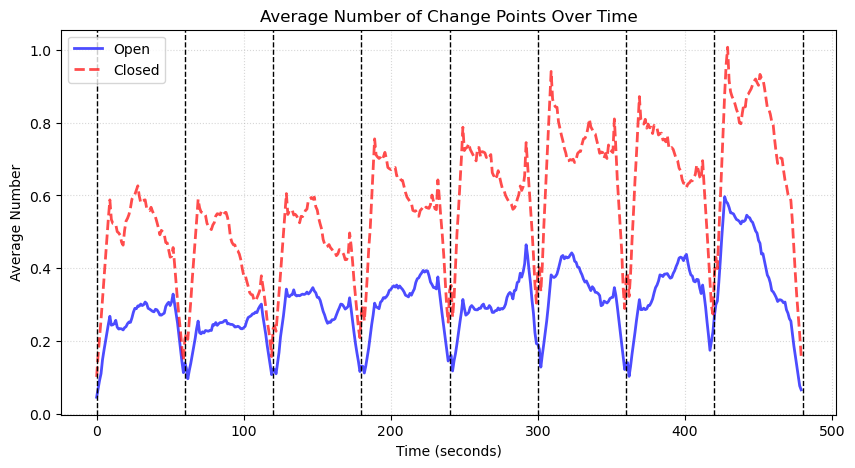

In [236]:
cumsum_cp_o = np.zeros([len(sub_ids), 8*60])
cumsum_cp_c = np.zeros([len(sub_ids), 8*60])

for sub in sub_ids:
    count_vec_o = get_cp_loc(subject=sub, all_regions=True, freq_band="alpha", eyeState=1)
    count_vec_c = get_cp_loc(subject=sub, all_regions=True, freq_band="alpha", eyeState=0)

    cumsum_cp_o[sub_ids.index(sub)] = create_count_vector(count_vec_o, moving_average=10)
    cumsum_cp_c[sub_ids.index(sub)] = create_count_vector(count_vec_c, moving_average=10)

avg_cumsum_o = cumsum_cp_o.mean(axis=0)
avg_cumsum_c = cumsum_cp_c.mean(axis=0)

plt.figure(figsize=(10, 5))  # Set figure size

plt.plot(avg_cumsum_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
plt.plot(avg_cumsum_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

# Add dashed black lines every 60 seconds
for t in range(0, max(len(count_o), 9*60), 60):
    plt.axvline(x=t, color="black", linestyle="--", linewidth=1)

plt.xlabel("Time (seconds)")
plt.ylabel("Average Number")
plt.title("Average Number of Change Points Over Time")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)  # Light dashed grid for better readability

plt.savefig("Figures/Average number of cp for all subjects"+ hyper_param+".png", dpi=300, bbox_inches="tight")

plt.show()

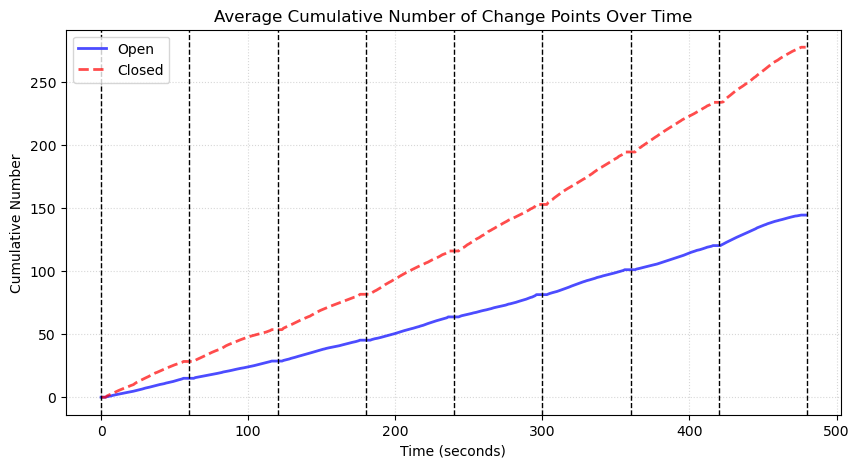

In [254]:
cumsum_cp_o = np.zeros([len(sub_ids), 8*60])
cumsum_cp_c = np.zeros([len(sub_ids), 8*60])

for sub in sub_ids:
    count_vec_o = get_cp_loc(subject=sub, all_regions=True,region=1, freq_band="alpha", eyeState=1)
    count_vec_c = get_cp_loc(subject=sub, all_regions=True, region=1, freq_band="alpha", eyeState=0)

    cumsum_cp_o[sub_ids.index(sub)] = counting_process(count_vec_o)
    cumsum_cp_c[sub_ids.index(sub)] = counting_process(count_vec_c)

avg_cumsum_o = cumsum_cp_o.mean(axis=0)
avg_cumsum_c = cumsum_cp_c.mean(axis=0)

plt.figure(figsize=(10, 5))  # Set figure size

plt.plot(avg_cumsum_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
plt.plot(avg_cumsum_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

# Add dashed black lines every 60 seconds
for t in range(0, max(len(count_o), 9*60), 60):
    plt.axvline(x=t, color="black", linestyle="--", linewidth=1)

plt.xlabel("Time (seconds)")
plt.ylabel("Cumulative Number")
plt.title("Average Cumulative Number of Change Points Over Time")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)  # Light dashed grid for better readability
#plt.savefig("Figures/Average cumulative number for all subjects alpha for region 1"+ hyper_param+".png", dpi=300, bbox_inches="tight")
plt.show()

In [235]:
def plot_average_cumsum(region = 1, freq_band = "alpha", all_regions = False):
    cumsum_cp_o = np.zeros([len(sub_ids), 8*60])
    cumsum_cp_c = np.zeros([len(sub_ids), 8*60])

    for sub in sub_ids:
        count_vec_o = get_cp_loc(subject=sub, region=region, freq_band=freq_band, eyeState=1, all_regions=all_regions)
        count_vec_c = get_cp_loc(subject=sub, region=region, freq_band=freq_band, eyeState=0, all_regions=all_regions)

        cumsum_cp_o[sub_ids.index(sub)] = counting_process(count_vec_o)
        cumsum_cp_c[sub_ids.index(sub)] = counting_process(count_vec_c)
    
    avg_cumsum_o = cumsum_cp_o.mean(axis=0)
    avg_cumsum_c = cumsum_cp_c.mean(axis=0)

    plt.figure(figsize=(10, 5))  # Set figure size

    plt.plot(avg_cumsum_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
    plt.plot(avg_cumsum_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

    # Add dashed black lines every 60 seconds
    for t in range(0, max(len(count_o), 9*60), 60):
        plt.axvline(x=t, color="black", linestyle="--", linewidth=1)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Cumulative Number")
    plt.title(f"Average Cumulative Number of Change Points Over Time (Region {region}, {freq_band.capitalize()} Band)")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.5)  # Light dashed grid for better readability
    plt.show()


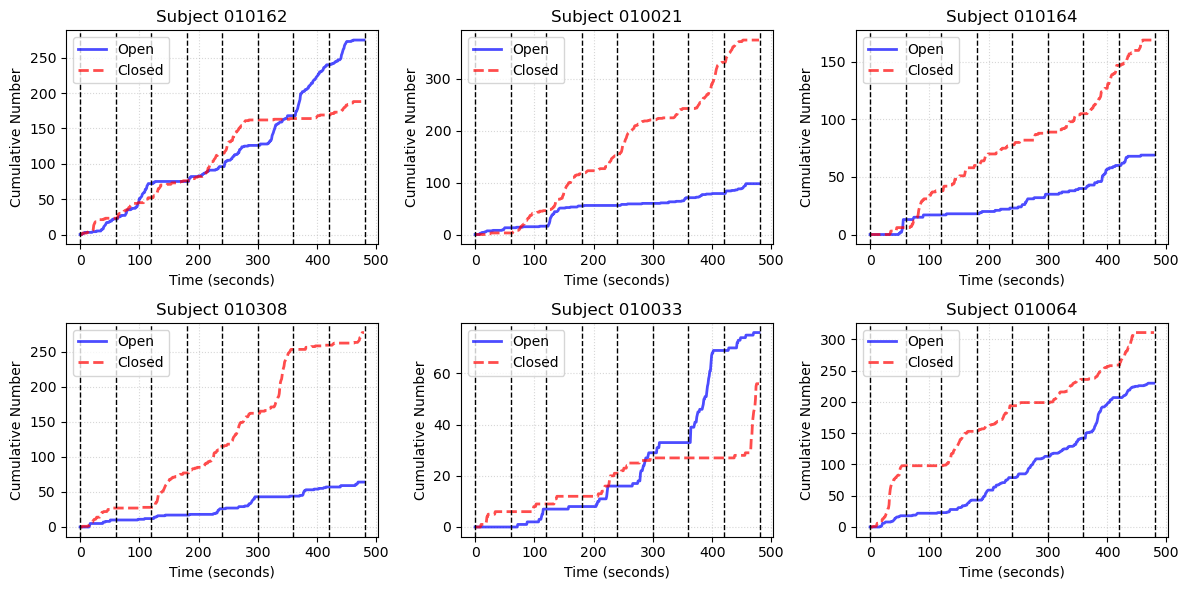

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Select 6 random unique subjects
np.random.seed(12)
random_subs = np.random.choice(sub_ids, size=6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # 2x3 figure layout

for idx, sub in enumerate(random_subs):
    count_vec_o = get_cp_loc(subject=sub, all_regions=True, freq_band="alpha", eyeState=1)
    count_vec_c = get_cp_loc(subject=sub, all_regions=True, freq_band="alpha", eyeState=0)

    count_o = counting_process(count_vec_o)
    count_c = counting_process(count_vec_c)

    ax = axes[idx // 3, idx % 3]  # Determine subplot position

    ax.plot(count_o, label="Open", linestyle="-", linewidth=2, alpha=0.7, color="blue")
    ax.plot(count_c, label="Closed", linestyle="--", linewidth=2, alpha=0.7, color="red")

    # Add dashed black lines every 60 seconds
    for t in range(0, max(len(count_o), 9 * 60), 60):
        ax.axvline(x=t, color="black", linestyle="--", linewidth=1)

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Cumulative Number")
    ax.set_title(f"Subject {sub}")
    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.5)

plt.tight_layout()
plt.savefig(f"Figures/Cumulative_number_of_cp_multiple_subjects{hyper_param}.png", dpi=300, bbox_inches="tight")
plt.show()
